# Image Search

<a href="https://colab.research.google.com/github/myscale/examples/blob/main/image-search.ipynb" style="padding-left: 0.5rem;"><img src="https://colab.research.google.com/assets/colab-badge.svg?style=plastic)](https://colab.research.google.com/github/myscale/examples/blob/main/image-search.ipynb)"></a><a href="https://github.com/myscale/examples/blob/main/image-search.ipynb" style="padding-left: 0.5rem;"><img src="https://img.shields.io/badge/Open-Github-blue.svg?logo=github&style=plastic)](https://github.com/myscale/examples/blob/main/image-search.ipynb)"></a>

## Introduction
Image search has become a popular and powerful application, enabling users to find similar images by matching features or visual content. With the rapid development of computer vision and deep learning, this capability has been greatly enhanced.

This guide is designed to help you leverage the latest techniques and tools for image search. In this guide, you will learn how to:
* Create a dataset with vector embeddings using a public dataset and model
* Perform image similarity search with MyScale, a powerful platform that streamlines the search process and provides fast and accurate results

If you're more interested in exploring capabilities of MyScale, feel free to skip the [Building dataset](#building-datasets) section and dive right into the [Populating data to MyScale](#populating-data-to-myscale) section.

## Prerequisites
Before we get started, we need to install the MyScale database python client and the HuggingFace `datasets` library to download sample data.

In [1]:
!pip install datasets myscaledb-client

To follow along with the steps outlined in the [Building dataset](#building-datasets) section, we need to install transformers and other necessary dependencies.

In [2]:
!pip install requests transformers torch tqdm

## Building dataset

### Downloading and processing data
We download data from [unsplash dataset](https://github.com/unsplash/datasets) and we use the Lite dataset.

In [3]:
!wget https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip

# unzip the downloaded files into a temporary directory
!unzip -o unsplash-research-dataset-lite-latest.zip -d tmp

--2023-02-23 11:27:55--  https://unsplash-datasets.s3.amazonaws.com/lite/latest/unsplash-research-dataset-lite-latest.zip
Resolving unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)... 52.216.37.185, 52.217.133.233, 3.5.16.126
Connecting to unsplash-datasets.s3.amazonaws.com (unsplash-datasets.s3.amazonaws.com)|52.216.37.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 632351052 (603M) [application/zip]
Saving to: 'unsplash-research-dataset-lite-latest.zip'

unsplash-research-d 100%[===================>] 603.06M  2.47MB/s    in 2m 21s  

2023-02-23 11:30:17 (4.29 MB/s) - 'unsplash-research-dataset-lite-latest.zip' saved [632351052/632351052]

Archive:  unsplash-research-dataset-lite-latest.zip
  inflating: tmp/collections.tsv000  
  inflating: tmp/__MACOSX/._collections.tsv000  
  inflating: tmp/colors.tsv000       
  inflating: tmp/__MACOSX/._colors.tsv000  
  inflating: tmp/conversions.tsv000  
  inflating: tmp/__MACOSX/._conversions

We read the downloaded data and transform it into Pandas dataframes.

In [4]:
import numpy as np
import pandas as pd
import glob

documents = ['photos', 'conversions']
datasets = {}

for doc in documents:
    files = glob.glob("tmp/" + doc + ".tsv*")
    subsets = []
    for filename in files:
        df = pd.read_csv(filename, sep='\t', header=0)
        subsets.append(df)
    datasets[doc] = pd.concat(subsets, axis=0, ignore_index=True)

df_photos = datasets['photos']
df_conversions = datasets['conversions']

### Generating image embeddings
To extract embeddings from images, we define an `extract_image_features` function that utilizes the [clip-vit-base-patch32](https://huggingface.co/openai/clip-vit-base-patch32) model from HuggingFace. The resulting embeddings are 512-dimensional vectors.

In [5]:
import torch
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained('openai/clip-vit-base-patch32')
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def extract_image_features(image):
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model.get_image_features(**inputs)
        outputs = outputs / outputs.norm(dim=-1, keepdim=True)
    return outputs.squeeze(0).tolist()

After that, we select the first 1000 photo IDs from the `df_photos` data frame, download the corresponding images, and extract their image embeddings using the extract_image_features function.

In [6]:
from PIL import Image
import requests
from tqdm.auto import tqdm

# select the first 1000 photo IDs
photo_ids = df_photos['photo_id'][:1000].tolist()

# create a new data frame with only the selected photo IDs
df_photos = df_photos[df_photos['photo_id'].isin(photo_ids)].reset_index(drop=True)

# keep only the columns 'photo_id' and 'photo_image_url' in the data frame
df_photos = df_photos[['photo_id', 'photo_image_url']]

# add a new column 'photo_embed' to the data frame
df_photos['photo_embed'] = None

# download the images and extract their embeddings using the 'extract_image_features' function
for i, row in tqdm(df_photos.iterrows(), total=len(df_photos)):
    # construct a URL to download an image with a smaller size by modifying the image URL
    url = row['photo_image_url'] + "?q=75&fm=jpg&w=200&fit=max"

    try:
        res = requests.get(url, stream=True).raw
        image = Image.open(res)
    except:
        # remove photo if image download fails
        photo_ids.remove(row['photo_id'])
        continue

    # extract feature embedding
    df_photos.at[i, 'photo_embed'] = extract_image_features(image)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Creating dataset
We now have two data frames: one for photo information with embeddings and the other for conversion information.

In [7]:
df_photos = df_photos[df_photos['photo_id'].isin(photo_ids)].reset_index(drop=True)

df_conversions = df_conversions[df_conversions['photo_id'].isin(photo_ids)].reset_index(drop=True)
df_conversions = df_conversions[['photo_id', 'keyword', 'conversion_country']]

Finally, we convert the dataframes into Parquet files and then proceed to upload them to the Hugging Face repository [myscale/unsplash-examples](https://huggingface.co/datasets/myscale/unsplash-examples) by following the [steps](https://huggingface.co/docs/datasets/upload_dataset). This facilitates easy access and sharing of the data.

In [8]:
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np

# create a Table object from the data and schema
photos_table = pa.Table.from_pandas(df_photos)
conversion_table = pa.Table.from_pandas(df_conversions)

# write the table to a Parquet file
pq.write_table(photos_table, 'photos.parquet')
pq.write_table(conversion_table, 'conversions.parquet')

## Populate data to MyScale

### Loading Data

To populate data to MyScale, first, we load data from the HuggingFace Dataset [myscale/unsplash-examples](https://huggingface.co/datasets/myscale/unsplash-examples) created in the previous section. The following code snippet shows how to load data and transform them into panda DataFrames.

Note: `photo_embed` is a 512-dimensional floating-point vector that represents the image features extracted from an image using the [CLIP](https://huggingface.co/openai/clip-vit-base-patch32) model.

In [9]:
from datasets import load_dataset

photos = load_dataset("myscale/unsplash-examples", data_files="photos.parquet", split="train")
conversions = load_dataset("myscale/unsplash-examples", data_files="conversions.parquet", split="train")

# transform datasets to panda Dataframe
photo_df = photos.to_pandas()
conversion_df = conversions.to_pandas()

# convert photo_embed from np array to list
photo_df['photo_embed'] = photo_df['photo_embed'].apply(lambda x: x.tolist())

Found cached dataset parquet (/Users/qingdizhang/.cache/huggingface/datasets/myscale___parquet/myscale--unsplash-examples-99b3662bb1ad2648/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Found cached dataset parquet (/Users/qingdizhang/.cache/huggingface/datasets/myscale___parquet/myscale--unsplash-examples-12854f3b2b9e9224/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [10]:
photo_df.head()

,photo_id,photo_image_url,photo_embed
0,XMyPniM9LF0,https://images.unsplash.com/uploads/1411949294...,"[-0.02423190325498581, 0.05229705199599266, 0...."
1,rDLBArZUl1c,https://images.unsplash.com/photo-141633941111...,"[-0.032578177750110626, 0.028756439685821533, ..."
2,cNDGZ2sQ3Bo,https://images.unsplash.com/photo-142014251503...,"[-0.03327571600675583, 0.051595136523246765, 0..."
3,iuZ_D1eoq9k,https://images.unsplash.com/photo-141487280988...,"[0.008161935955286026, 0.00707155792042613, -0..."
4,BeD3vjQ8SI0,https://images.unsplash.com/photo-141700759404...,"[-0.01028392929583788, -0.0009960911702364683,..."


In [11]:
conversion_df.head()

,photo_id,keyword,conversion_country
0,Knwea-mLGAg,starry sky,TW
1,AZMmUy2qL6A,camping,KR
2,agE97zp_Xvo,lonely,IN
3,EXbGG5dBZKw,happy,CN
4,EWDvHNNfUmQ,wood,EC


### Creating table
Next, we create tables in MyScale. Before you begin, you will need to retrieve your cluster URL, username, and password information from the MyScale console. The following code snippet creates two tables, one for photo information and the other for conversion information.

In [11]:
from myscaledb import Client

# initialize MyScale client
client = Client(url="YOUR_CLUSTER_URL", user="YOUR_USERNAME", password="YOUR_CLUSTER_PASSWORD")

assert client.is_alive()

# drop table if existed
client.execute("DROP TABLE IF EXISTS default.photos")
client.execute("DROP TABLE IF EXISTS default.conversions")

# create table for photos
client.execute("""
CREATE TABLE default.photos
(
    id UInt64,
    photo_id String,
    photo_url String,
    photo_embed Array(Float32),
    CONSTRAINT vector_len CHECK length(photo_embed) = 512
)
ENGINE = MergeTree ORDER BY id
""")

# create table for conversions
client.execute("""
CREATE TABLE default.conversions
(
    id UInt64,
    photo_id String,
    keyword String,
    conversion_country String
)
ENGINE = MergeTree ORDER BY id
""")

### Uploading Data
After creating the tables, we insert data loaded from the datasets into tables and create a vector index to accelerate later vector search queries. The following code snippet shows how to insert data into tables and create a vector index with cosine distance metric.

In [12]:
# upload data from datasets
client.execute("INSERT INTO default.photos VALUES", photo_df.to_records(index=True).tolist())
client.execute("INSERT INTO default.conversions VALUES", conversion_df.to_records(index=True).tolist())

# check count of inserted data
print(f"photos count: {client.fetchval(query='SELECT count(*) FROM default.photos')}")
print(f"conversions count: {client.fetchval(query='SELECT count(*) FROM default.conversions')}")

# create vector index with cosine
client.execute("""
ALTER TABLE default.photos 
ADD VECTOR INDEX photo_embed_index photo_embed
TYPE HNSWFLAT
('metric_type=Cosine')
""")

photos count: 963
conversions count: 607209


In [13]:
# check the status of the vector index, make sure vector index is ready with 'Built' status
get_index_status="SELECT status FROM system.vector_indices WHERE table='photos'"
print(f"index build status: {client.fetchval(query=get_index_status)}")

index build status: Built


## Query MyScale

### Finding top K similar images

To find the top K similar images using vector search, follow these steps:

First, let's randomly select an image and display it using the show_image() function.

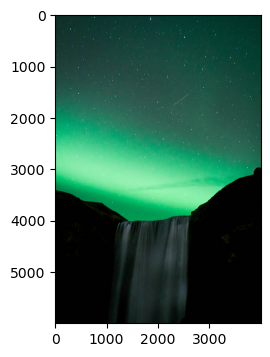

In [14]:
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import random

def download(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

# pick a random image
img_id = random.randint(0, len(photo_df)-1)
url = photo_df.loc[img_id, 'photo_image_url']
img = download(url)

# display
fig = plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.show()

Then, use vector search to identify the top K candidates that are most similar to the selected image, and display these candidates:

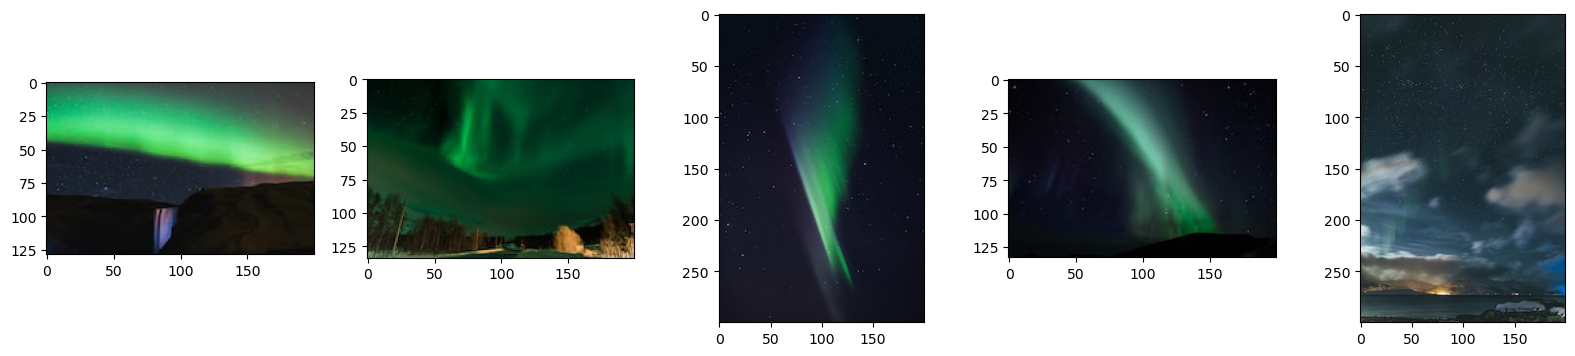

In [16]:
query_photo = photo_df.loc[img_id, 'photo_id']
query_embed = photo_df.loc[img_id, 'photo_embed']

# query the database to find the top K similar images to the given image
top_k = 5
results = client.fetch(f"""
SELECT photo_id, distance('topK={top_k}')(photo_embed, {query_embed}) as dist
FROM default.photos
WHERE photo_id != '{query_photo}'""")

# download the images and add them to a list
images = []
for r in results:
    # construct a URL to download an image with a smaller size by modifying the image URL
    url = photo_df.loc[photo_df['photo_id'] == r[0], 'photo_image_url'].item() + "?q=75&fm=jpg&w=200&fit=max"
    images.append(download(url))

# display similar images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, img in enumerate(images):
    axs[i].imshow(img)
plt.show()

### Analyzing conversion information for each candidate image

After identifying the top K similar images, you can use SQL queries combining structured fields and vector fields to perform analysis on the conversion information for each candidate.

To calculate the total conversion count for each candidate image, you can use the following SQL query to join the image search results with the `conversions` table:

In [17]:
top_k = 5
results = client.fetch(f"""
SELECT photo_id, count(*) as count
FROM default.conversions
JOIN default.photos
ON default.conversions.photo_id = default.photos.photo_id
WHERE photo_id IN (
    SELECT photo_id FROM (
        SELECT photo_id, distance('topK={top_k}')(photo_embed, {query_embed}) as dist
        FROM default.photos
        ORDER BY dist DESC
    )
    LIMIT {top_k}
)
GROUP BY photo_id
ORDER BY count DESC
""")

print("Total downloads for each candidate")
for r in results:
    photo_id, conversion_count = r[0], r[1]
    print(f"- {photo_id}: {conversion_count}")

Total downloads for each candidate
- xGltqb1ChYw: 765
- zWQLnfMBxFI: 368
- XxXaqVlBkOM: 101
- gGMhd5wRFvo: 80
- P_J3chFYwIU: 31


After calculating the total conversion count for each candidate image, you can identify the candidate image with the most downloads, and examine the detailed conversion information per country for that image. Use the following SQL query:

In [18]:
most_popular_candidate = results[0][0]

top_k = 10
results = client.fetch("""
SELECT conversion_country, count(*) as count
FROM default.conversions
WHERE photo_id='{}'
GROUP BY conversion_country
ORDER BY count DESC
LIMIT 5
""".format(most_popular_candidate))

print(f"Downloads for '{most_popular_candidate}':")
for r in results:
    conversion_country, count = r[0], r[1]
    print(f"- {conversion_country}: {count}")

Downloads for 'xGltqb1ChYw':
- US: 89
- KR: 62
- CN: 53
- ID: 45
- IN: 38
